In [56]:
import cv2
import numpy as np 
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf 
import matplotlib.pyplot as plt 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

train_dir = '/Users/jayanshbhartiya/desktop/internship/tensorflow/Siraj /Convolution/data/train'
test_dir = '/Users/jayanshbhartiya/Desktop/Internship/tensorflow/Siraj /Convolution/data/test'
img_size = 50 
learning_rate = 1e-3

model_name = 'dogsvscats-{}-{}.model'.format(learning_rate,'2conv-basic-video')

def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat':
        return [1,0]
    else:
        return [0,1]
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        path = os.path.join(train_dir,img)
        label = label_img(img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size,img_size))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data
  
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size,img_size))
        testing_data.append([np.array(img),np.array(img_num)])
    shuffle(testing_data)
    np.save('test_data.npy',testing_data)
    return testing_data

In [57]:
train_data = create_train_data()




100%|██████████| 25000/25000 [00:42<00:00, 582.34it/s]


In [35]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()

convnet = input_data(shape=[None, img_size, img_size, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=learning_rate, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [36]:
if os.path.exists('{}.meta'.format(model_name)):
    model.load(model_name)
    print('model loaded')

In [37]:
train = train_data[:-500]
test = train_data[-500:]


In [38]:
x_train = np.array([i[0] for i in train]).reshape(-1,img_size,img_size,1)
y_train = np.array([i[1] for i in train])

In [39]:
x_test = np.array([i[0] for i in test]).reshape(-1,img_size,img_size,1)
y_test = np.array([i[1] for i in test])

In [40]:
model.fit({'input': x_train}, {'targets': y_train}, n_epoch=5, validation_set=({'input': x_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=model_name)

Training Step: 1914  | total loss: 0.46320 | time: 30.408s
| Adam | epoch: 005 | loss: 0.46320 - acc: 0.7769 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.45931 | time: 31.495s
| Adam | epoch: 005 | loss: 0.45931 - acc: 0.7820 | val_loss: 0.47149 - val_acc: 0.7840 -- iter: 24500/24500
--


In [41]:
model.save(model_name)

INFO:tensorflow:/Users/jayanshbhartiya/Desktop/Internship/tensorflow/Sentdex/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:09<00:00, 1292.53it/s]


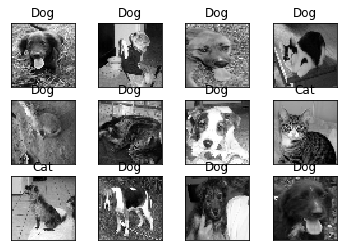

In [59]:
import matplotlib.pyplot as plt 

#if you dont have this file yet 
test_data = create_test_data()

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0:1]
    
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size,img_size,1)
    
    model_out = model.predict([data])[0]
    
    if(np.argmax(model_out)) == 1: 
        str_label = 'Dog' 
    else:
        str_label = 'Cat'
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    
        